# KMT: Keras Motion Transfer Tutorial

**Author**: ABHAS KUMAR SINHA

**Date Created**: 08-04-2025

**Abstract**: Demonstrate KMT Module for motion transfer to static images, this is a dummy example notebook.

In [1]:
!git clone https://github.com/abhaskumarsinha/KMT.git
%cd KMT

Cloning into 'KMT'...
remote: Enumerating objects: 201, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (189/189), done.
remote: Total 201 (delta 114), reused 18 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (201/201), 146.87 KiB | 14.69 MiB/s, done.
Resolving deltas: 100% (114/114), done.
/content/KMT


In [2]:
from src.models.keypoint_detector import *
from src.models.generator import *
from src.models.discriminator import *

## Load Dataset
We place a small dataset of some (256, 256, 3) videos in dataset folder in KMT

In [3]:
video_dataset = VideoDataLoader('dataset',
                               max_frames = 100, # 1 example video for dummy tutorial
                               num_vids = 1) # Num of frames from each vid, if less then append last frame, if more then crop
videos = video_dataset.get_batch()
video_dataset.get_stats()

{'total_videos': 1,
 'average_frames': np.float64(148.0),
 'min_frames': np.int64(148),
 'max_frames': np.int64(148)}

In [4]:
(X0, X1), Y = create_dataset(videos)

## Model Architecture.
Requires - one Upscaling module, one `(num keypoints+1)*2` num channel to `num keypoints+1` channel DL module and one discriminator for `256, 256, 1` image (like GANs).

In [14]:
kp_detector = KeypointDetector(num_keypoints = 5)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(256, 256, 12)),
    Activation('relu'),

    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),

    Conv2D(6, (1, 1), padding='same'),  # Final output layer
    Activation('sigmoid')  # Use sigmoid for normalized output, or linear for raw
])

# Model summary (optional)
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 256, 256, 32)        │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 256, 256, 6)         │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256, 256, 6)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,374 (87.40 KB)

 Trainable params: 22,374 (87.40 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, UpSampling2D, Activation

upscaler = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(30, 30, 1)),
    Activation('relu'),

    UpSampling2D(size=(2, 2)),  # 30x30 -> 60x60
    Conv2D(32, (3, 3), padding='same'),
    Activation('relu'),

    UpSampling2D(size=(2, 2)),  # 60x60 -> 120x120
    Conv2D(16, (3, 3), padding='same'),
    Activation('relu'),

    UpSampling2D(size=(2, 2)),  # 120x120 -> 240x240
    Conv2D(8, (3, 3), padding='same'),
    Activation('relu'),

    UpSampling2D(size=(2, 2)),  # 240x240 -> 480x480
    Conv2D(1, (3, 3), padding='same'),
    Activation('sigmoid'),

    # Optional: Crop back to 256x256 if needed
])

# Add cropping layer if you want exactly (256, 256, 1)
from tensorflow.keras.layers import Cropping2D
upscaler.add(Cropping2D(cropping=((112, 112), (112, 112))))  # 480x480 -> 256x256

# Model summary (optional)
upscaler.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 120, 120, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 120, 120, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 240, 240, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 240, 240, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 240, 240, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 480, 480, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 480, 480, 1)         │              73 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 480, 480, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 256, 256, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,425 (60.25 KB)

 Trainable params: 15,425 (60.25 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
generator = KeypointBasedTransform(batch_size = 10, target_size = (30, 30), num_keypoints = 5, model = model, upscaler = upscaler)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten, Dense, Dropout

discriminator = Sequential([
    Conv2D(64, (4, 4), strides=2, padding='same', input_shape=(256, 256, 1)),
    LeakyReLU(alpha=0.2),

    Conv2D(128, (4, 4), strides=2, padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),

    Conv2D(256, (4, 4), strides=2, padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),

    Conv2D(512, (4, 4), strides=2, padding='same'),
    LeakyReLU(alpha=0.2),
    Dropout(0.3),

    Flatten(),
    Dense(1, activation='sigmoid')  # Output: probability of real (1) or fake (0)
])

# Model summary (optional)
discriminator.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 128, 128, 64)        │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,885,569 (11.01 MB)

 Trainable params: 2,885,569 (11.01 MB)

 Non-trainable params: 0 (0.00 B)

## Lesssss Gooooooooooo

Warmup to align Jacobians so that inverse during forward inference doesn't becomes infinity. (DET(J) != 0).

Train for at least 700 epochs for the best results on a bigger model and dataset.

In [19]:
models = setup_keypoint_pipeline(kp_detector,
                                 generator,
                                 discriminator,
                                 image_size=(256, 256, 1),
                                 batch_size = 10,
                                 warmup_samples = 100,
                                 num_keypoints = 5)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.4512
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.3755
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2875
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1858
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0865
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0220
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0240
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0542
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0488
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0217

🧱 GAN Summary:


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoint_detector_1       │ [(None, 5, 2), (None,  │         26,361 │ input_layer_14[0][0],  │
│ (KeypointDetector)        │ 5, 2, 2)]              │                │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keypoint_based_transform… │ (10, 256, 256, 1)      │         38,184 │ input_layer_14[0][0],  │
│ (KeypointBasedTransform)  │                        │                │ keypoint_detector_1[1… │
│                           │                        │                │ keypoint_detector_1[1… │
│                           │                        │                │ keypoint_detector_1[2… │
│                           │                        │                │ keypoint_detector_1[2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_9 (Sequential) │ (10, 1)                │      2,885,569 │ keypoint_based_transf… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,950,114 (11.25 MB)

 Trainable params: 2,950,114 (11.25 MB)

 Non-trainable params: 0 (0.00 B)


🧱 Generator Backbone Summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 256, 256, 32)        │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 256, 256, 6)         │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 256, 256, 6)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,374 (87.40 KB)

 Trainable params: 22,374 (87.40 KB)

 Non-trainable params: 0 (0.00 B)


🧱 Generator Upscaler Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)                   │ (None, 30, 30, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 120, 120, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 120, 120, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 240, 240, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 240, 240, 8)         │           1,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 240, 240, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_7 (UpSampling2D)       │ (None, 480, 480, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 480, 480, 1)         │              73 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 480, 480, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 256, 256, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,425 (60.25 KB)

 Trainable params: 15,425 (60.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
models

{'gan': <Functional name=functional_17, built=True>,
 'generator_model': <Functional name=functional_16, built=True>,
 'keypoint_detector': <KeypointDetector name=keypoint_detector_1, built=True>,
 'discriminator': <Sequential name=sequential_9, built=True>,
 'aligner': <Functional name=functional_15, built=True>}

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Discriminator Loss (real): 0.31173626
GAN Loss (G): 1.8757296
GAN Loss (D): 1.77153


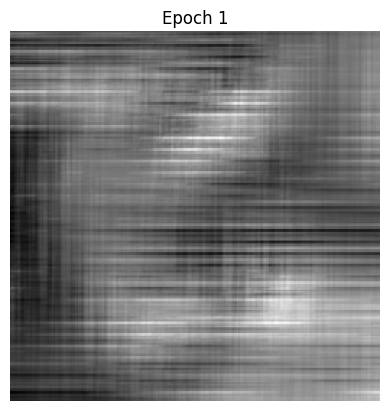

Epochs:   5%|▌         | 1/20 [01:44<32:57, 104.09s/it]

Epoch 2/20


Epochs:  10%|█         | 2/20 [01:45<13:02, 43.49s/it] 

Epoch 3/20


Epochs:  15%|█▌        | 3/20 [01:46<06:49, 24.11s/it]

Epoch 4/20


Epochs:  20%|██        | 4/20 [01:47<04:00, 15.01s/it]

Epoch 5/20


Epochs:  25%|██▌       | 5/20 [01:48<02:29,  9.98s/it]

Epoch 6/20
Discriminator Loss (real): 0.05196728
GAN Loss (G): 20.730062
GAN Loss (D): 20.538116


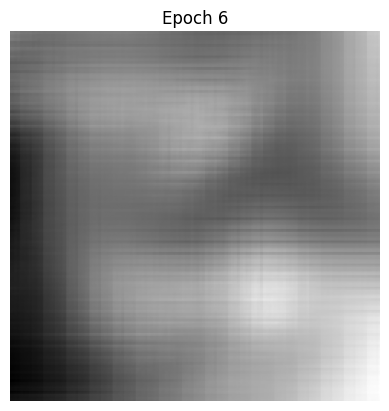

Epochs:  30%|███       | 6/20 [01:51<01:46,  7.63s/it]

Epoch 7/20


Epochs:  35%|███▌      | 7/20 [01:52<01:11,  5.51s/it]

Epoch 8/20


Epochs:  40%|████      | 8/20 [01:53<00:49,  4.10s/it]

Epoch 9/20


Epochs:  45%|████▌     | 9/20 [01:54<00:34,  3.16s/it]

Epoch 10/20


Epochs:  50%|█████     | 10/20 [01:55<00:25,  2.51s/it]

Epoch 11/20
Discriminator Loss (real): 0.02834579
GAN Loss (G): 23.451258
GAN Loss (D): 23.332817


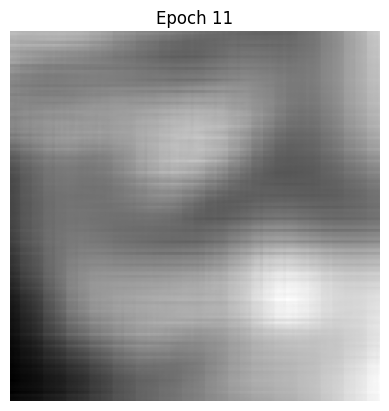

Epochs:  55%|█████▌    | 11/20 [01:58<00:23,  2.56s/it]

Epoch 12/20


Epochs:  60%|██████    | 12/20 [01:59<00:16,  2.12s/it]

Epoch 13/20


Epochs:  65%|██████▌   | 13/20 [02:00<00:12,  1.81s/it]

Epoch 14/20


Epochs:  70%|███████   | 14/20 [02:01<00:09,  1.59s/it]

Epoch 15/20


Epochs:  75%|███████▌  | 15/20 [02:02<00:07,  1.46s/it]

Epoch 16/20
Discriminator Loss (real): 0.019487731
GAN Loss (G): 24.490076
GAN Loss (D): 24.40504


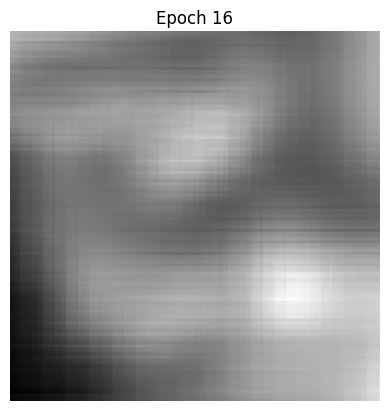

Epochs:  80%|████████  | 16/20 [02:05<00:07,  1.83s/it]

Epoch 17/20


Epochs:  85%|████████▌ | 17/20 [02:06<00:04,  1.61s/it]

Epoch 18/20


Epochs:  90%|█████████ | 18/20 [02:07<00:02,  1.46s/it]

Epoch 19/20


Epochs:  95%|█████████▌| 19/20 [02:08<00:01,  1.35s/it]

Epoch 20/20


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.50s/it]

Training complete.


In [21]:
train_motion_model((X0, X1), Y,
                   models['generator_model'],
                   models['gan'],
                   models['discriminator'],
                   batch_size=10,
                   epochs=20,
                   save_path='../',
                   preview_interval=5)

## Visualization of the model.

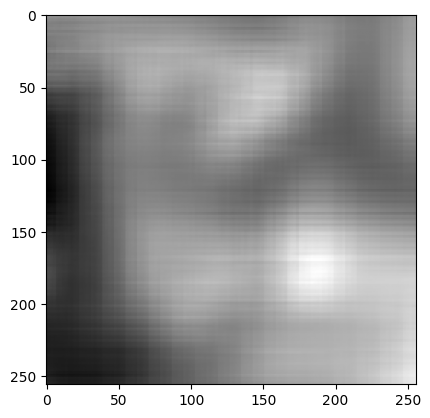

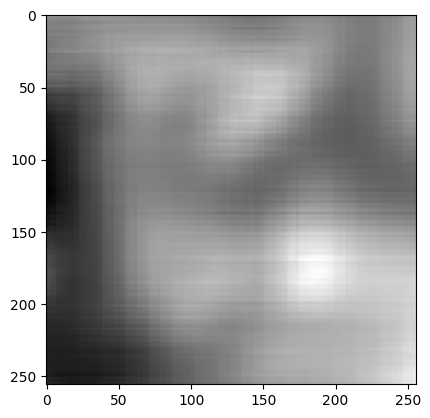

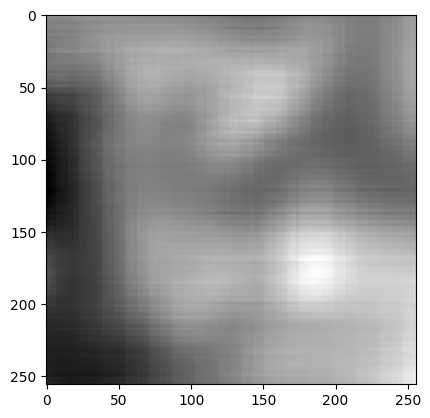

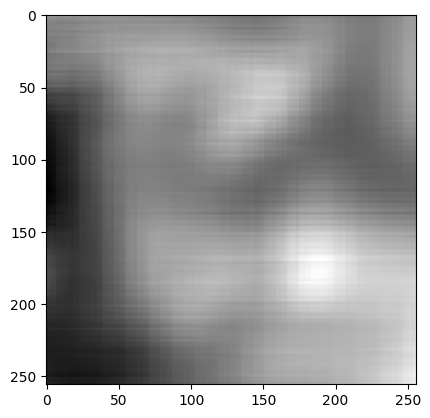

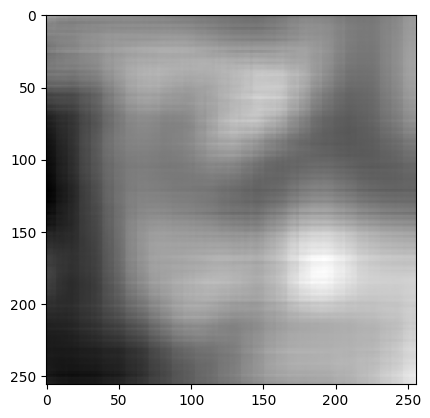

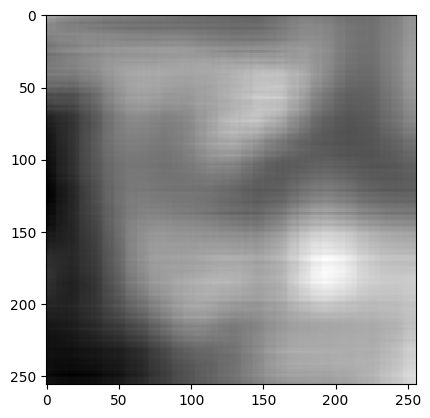

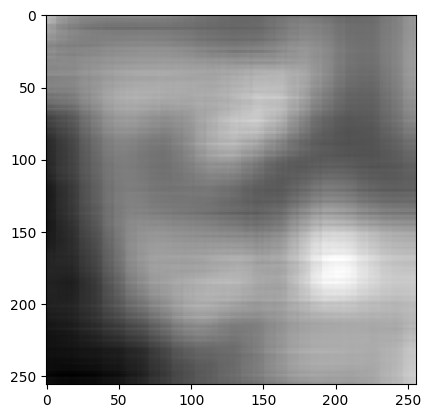

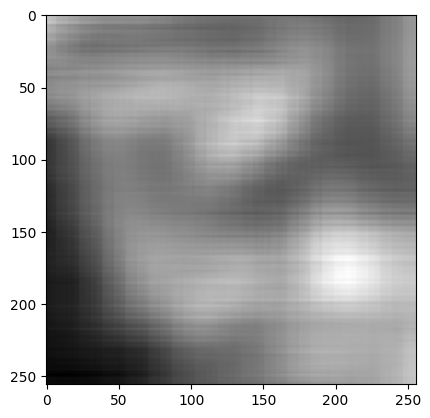

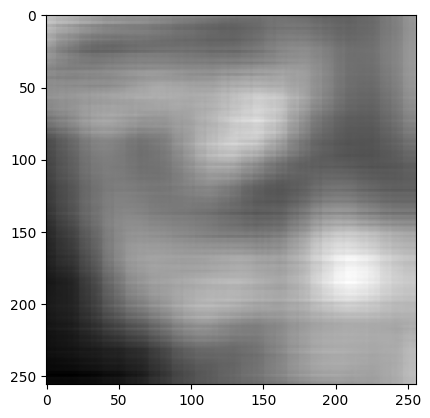

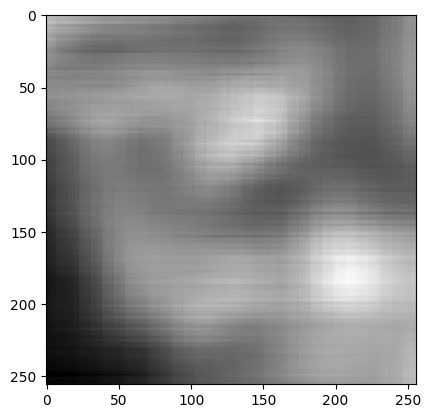

In [22]:
import os

models['generator_model'].layers[-1].batch_size = 1

start_frame, end_frame = 0, 10
for frame_number in range(start_frame, end_frame):
    output = models['generator_model']((X0[frame_number: frame_number+1],
                                  X1[frame_number: frame_number+1]))
    plt.imshow(output[0], cmap='gray')
    plt.show()